In [1]:
import json
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class PieDataset(Dataset):
    def __init__(
        self,
        json_path,
        image_root,
        # transforms
    ):
        self.json_path = json_path
        self.image_root = image_root
        
        with open(json_path, "r") as f:
            json_dict = json.load(f)
        self.df_images = pd.DataFrame(json_dict["images"])
        self.df_anno = pd.DataFrame(json_dict['annotations'])

        self.image_len = len(self.df_images)
        
        self.transforms = A.Compose([
            A.RandomCrop(width=258, height=258),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy'))

    def __len__(self):
        return self.image_len
    
    def __getitem__(self, idx):
        image_path = self.image_root + self.df_images.iloc[idx]["file_name"]
        image_id = self.df_images.iloc[idx]["id"]
        annotations = self.df_anno[self.df_anno["image_id"] == image_id]

        PIL_image = PIL.Image.open(image_path)
        image = np.array(PIL_image)/255.
        PIL_image.close()
        image, keypoints = self.square_pad(image, annotations)
        keypoints = self.get_xyform_kp(keypoints)

        transformed = self.transforms(image=image, keypoints=keypoints)
        transformed_image = transformed['image']
        transformed_keypoints = transformed['keypoints']

        return transformed_image, transformed_keypoints



    def square_pad(self, image, annotations):
        # Pad to make square
        H, W, C = image.shape
        if H != W:
            long, short = max(H, W), min(H, W)
            pad_size, is_odd = divmod(long-short, 2)

            # v_pad
            if long == W:
                up_pad = np.zeros([pad_size, W, C])
                down_pad = np.zeros([pad_size + is_odd, W, C])
                image = np.concatenate(
                    (up_pad, image, down_pad), axis = 0
                )
                shifted_kp = []
                for key_points in annotations["bbox"]:
                    x1,y1, x2,y2, x3,y3 = key_points
                    shifted_kp.append([
                        x1, y1+pad_size,
                        x2, y2+pad_size,
                        x3, y3+pad_size
                    ])

            # h_pad
            elif long == H:
                left_pad = np.zeros([H, pad_size, C])
                right_pad = np.zeros([H, pad_size + is_odd, C])
                image = np.concatenate(
                    (left_pad, image, right_pad), axis = 1
                )
                shifted_kp = []
                for key_points in annotations["bbox"]:
                    x1,y1, x2,y2, x3,y3 = key_points
                    shifted_kp.append([
                        x1+pad_size, y1,
                        x2+pad_size, y2,
                        x3+pad_size, y3
                    ])
        return image, shifted_kp
    
    def get_xyform_kp(self, kps):
        xy_form = []
        for kp in kps:
            if len(kp) != 6:
                raise ValueError("invalid kepoint shape")
            xy_form.append((kp[0], kp[1], "value_point"))
            xy_form.append((kp[2], kp[3], "value_point"))
            xy_form.append((kp[4], kp[5], "center_point"))
        return xy_form

In [3]:
data_root = "/home/davi/workspace/data/piedata(1008)/pie/"
data_json = data_root + "annotations/instancesPie(1008)_train2019.json"
dataset = PieDataset(
    json_path=data_json,
    image_root=data_root+"images/train2019/"
)

torch.Size([4, 258, 258]) [(214.0, 147.0, 'value_point'), (111.0, 248.0, 'value_point'), (109.0, 143.0, 'center_point'), (111.0, 248.0, 'value_point'), (214.0, 143.0, 'value_point'), (109.0, 143.0, 'center_point'), (214.0, 143.0, 'value_point'), (214.0, 147.0, 'value_point'), (109.0, 143.0, 'center_point')]


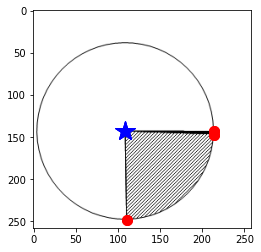

torch.Size([4, 258, 258]) [(154.0, 158.0, 'center_point'), (154.0, 158.0, 'center_point'), (154.0, 158.0, 'center_point')]


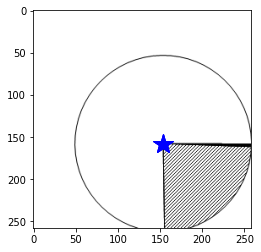

torch.Size([4, 258, 258]) [(251.0, 107.0, 'value_point'), (148.0, 208.0, 'value_point'), (146.0, 103.0, 'center_point'), (148.0, 208.0, 'value_point'), (251.0, 103.0, 'value_point'), (146.0, 103.0, 'center_point'), (251.0, 103.0, 'value_point'), (251.0, 107.0, 'value_point'), (146.0, 103.0, 'center_point')]


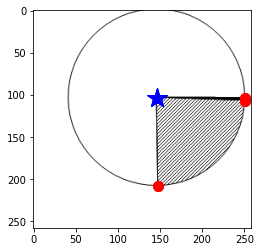

torch.Size([4, 258, 258]) [(218.0, 150.0, 'value_point'), (115.0, 251.0, 'value_point'), (113.0, 146.0, 'center_point'), (115.0, 251.0, 'value_point'), (218.0, 146.0, 'value_point'), (113.0, 146.0, 'center_point'), (218.0, 146.0, 'value_point'), (218.0, 150.0, 'value_point'), (113.0, 146.0, 'center_point')]


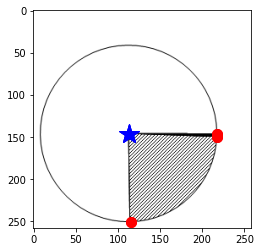

torch.Size([4, 258, 258]) [(196.0, 102.0, 'value_point'), (93.0, 203.0, 'value_point'), (91.0, 98.0, 'center_point'), (93.0, 203.0, 'value_point'), (196.0, 98.0, 'value_point'), (91.0, 98.0, 'center_point'), (196.0, 98.0, 'value_point'), (196.0, 102.0, 'value_point'), (91.0, 98.0, 'center_point')]


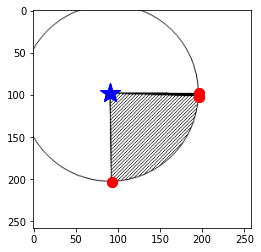

torch.Size([4, 258, 258]) [(202.0, 123.0, 'value_point'), (99.0, 224.0, 'value_point'), (97.0, 119.0, 'center_point'), (99.0, 224.0, 'value_point'), (202.0, 119.0, 'value_point'), (97.0, 119.0, 'center_point'), (202.0, 119.0, 'value_point'), (202.0, 123.0, 'value_point'), (97.0, 119.0, 'center_point')]


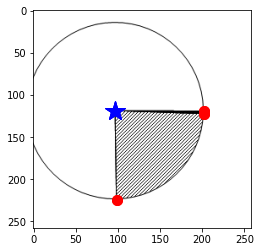

torch.Size([4, 258, 258]) [(218.0, 126.0, 'value_point'), (115.0, 227.0, 'value_point'), (113.0, 122.0, 'center_point'), (115.0, 227.0, 'value_point'), (218.0, 122.0, 'value_point'), (113.0, 122.0, 'center_point'), (218.0, 122.0, 'value_point'), (218.0, 126.0, 'value_point'), (113.0, 122.0, 'center_point')]


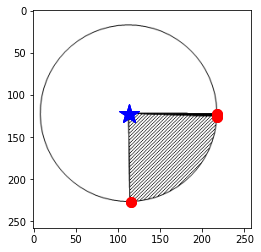

torch.Size([4, 258, 258]) [(199.0, 144.0, 'value_point'), (96.0, 245.0, 'value_point'), (94.0, 140.0, 'center_point'), (96.0, 245.0, 'value_point'), (199.0, 140.0, 'value_point'), (94.0, 140.0, 'center_point'), (199.0, 140.0, 'value_point'), (199.0, 144.0, 'value_point'), (94.0, 140.0, 'center_point')]


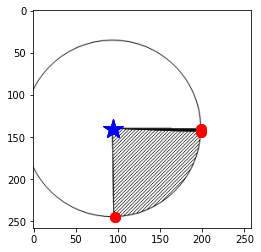

torch.Size([4, 258, 258]) [(206.0, 166.0, 'value_point'), (101.0, 162.0, 'center_point'), (206.0, 162.0, 'value_point'), (101.0, 162.0, 'center_point'), (206.0, 162.0, 'value_point'), (206.0, 166.0, 'value_point'), (101.0, 162.0, 'center_point')]


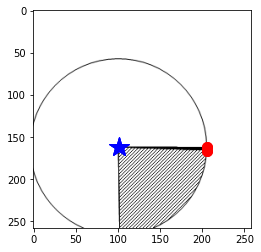

torch.Size([4, 258, 258]) [(194.0, 149.0, 'value_point'), (91.0, 250.0, 'value_point'), (89.0, 145.0, 'center_point'), (91.0, 250.0, 'value_point'), (194.0, 145.0, 'value_point'), (89.0, 145.0, 'center_point'), (194.0, 145.0, 'value_point'), (194.0, 149.0, 'value_point'), (89.0, 145.0, 'center_point')]


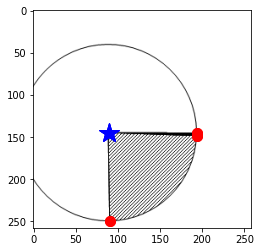

In [4]:
for i in range(10):
    img, kps = dataset[0]
    print(img.shape, kps)
    plt.imshow(img.permute(1,2,0))
    for kp in kps:
        marker = ".r" if kp[2] == "value_point" else "*b"
        plt.plot(kp[0], kp[1], marker, markersize=20)
    plt.show()

torch.Size([4, 258, 258]) [(195.0, 104.0, 'value_point'), (92.0, 205.0, 'value_point'), (90.0, 100.0, 'center_point'), (92.0, 205.0, 'value_point'), (195.0, 100.0, 'value_point'), (90.0, 100.0, 'center_point'), (195.0, 100.0, 'value_point'), (195.0, 104.0, 'value_point'), (90.0, 100.0, 'center_point')]


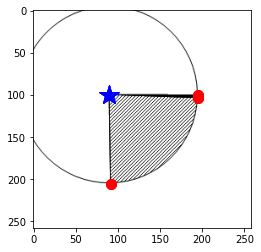

torch.Size([4, 258, 258]) [(254.0, 94.0, 'value_point'), (170.0, 193.0, 'value_point'), (148.0, 89.0, 'center_point'), (170.0, 193.0, 'value_point'), (254.0, 90.0, 'value_point'), (148.0, 89.0, 'center_point'), (254.0, 90.0, 'value_point'), (254.0, 94.0, 'value_point'), (148.0, 89.0, 'center_point')]


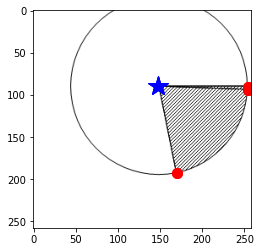

torch.Size([4, 258, 258]) [(156.0, 106.0, 'value_point'), (156.0, 106.0, 'value_point'), (215.0, 39.0, 'value_point'), (215.0, 39.0, 'value_point'), (240.0, 28.0, 'value_point'), (240.0, 28.0, 'value_point')]


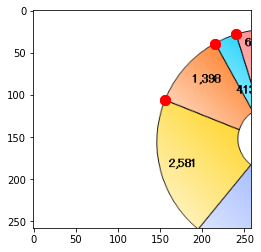

torch.Size([4, 258, 258]) [(211.0, 113.0, 'value_point'), (211.0, 113.0, 'value_point')]


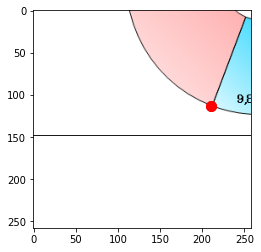

torch.Size([4, 258, 258]) [(123.0, 94.0, 'value_point'), (147.0, 98.0, 'value_point'), (122.0, 160.0, 'center_point'), (147.0, 98.0, 'value_point'), (167.0, 110.0, 'value_point'), (122.0, 160.0, 'center_point'), (167.0, 110.0, 'value_point'), (74.0, 116.0, 'value_point'), (122.0, 160.0, 'center_point'), (74.0, 116.0, 'value_point'), (100.0, 98.0, 'value_point'), (122.0, 160.0, 'center_point'), (100.0, 98.0, 'value_point'), (123.0, 94.0, 'value_point'), (122.0, 160.0, 'center_point')]


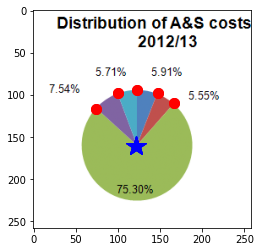

torch.Size([4, 258, 258]) [(100.0, 20.0, 'value_point'), (122.0, 24.0, 'value_point'), (100.0, 85.0, 'center_point'), (122.0, 24.0, 'value_point'), (145.0, 38.0, 'value_point'), (100.0, 85.0, 'center_point'), (145.0, 38.0, 'value_point'), (52.0, 41.0, 'value_point'), (100.0, 85.0, 'center_point'), (52.0, 41.0, 'value_point'), (77.0, 24.0, 'value_point'), (100.0, 85.0, 'center_point'), (77.0, 24.0, 'value_point'), (100.0, 20.0, 'value_point'), (100.0, 85.0, 'center_point')]


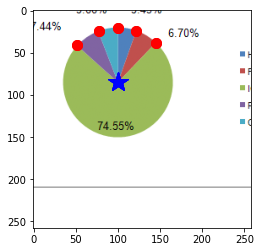

torch.Size([4, 258, 258]) []


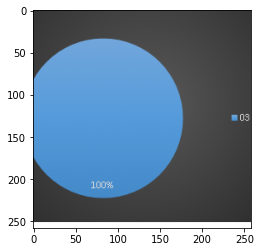

torch.Size([4, 258, 258]) [(118.0, 230.0, 'value_point'), (118.0, 38.0, 'value_point'), (117.0, 134.0, 'center_point'), (118.0, 38.0, 'value_point'), (146.0, 226.0, 'value_point'), (117.0, 134.0, 'center_point'), (146.0, 226.0, 'value_point'), (118.0, 230.0, 'value_point'), (117.0, 134.0, 'center_point')]


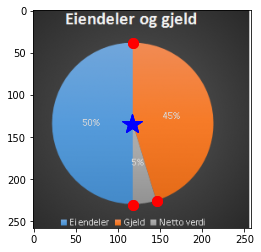

torch.Size([4, 258, 258]) [(192.0, 42.0, 'value_point'), (191.0, 198.0, 'center_point'), (192.0, 42.0, 'value_point'), (191.0, 198.0, 'center_point'), (191.0, 198.0, 'center_point')]


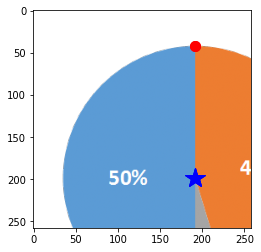

torch.Size([4, 258, 258]) [(136.0, 172.0, 'value_point'), (172.0, 210.0, 'value_point'), (136.0, 208.0, 'center_point'), (172.0, 210.0, 'value_point'), (126.0, 243.0, 'value_point'), (136.0, 208.0, 'center_point'), (126.0, 243.0, 'value_point'), (123.0, 242.0, 'value_point'), (136.0, 208.0, 'center_point'), (123.0, 242.0, 'value_point'), (105.0, 189.0, 'value_point'), (136.0, 208.0, 'center_point'), (105.0, 189.0, 'value_point'), (127.0, 173.0, 'value_point'), (136.0, 208.0, 'center_point'), (127.0, 173.0, 'value_point'), (135.0, 172.0, 'value_point'), (136.0, 208.0, 'center_point'), (135.0, 172.0, 'value_point'), (136.0, 172.0, 'value_point'), (136.0, 208.0, 'center_point')]


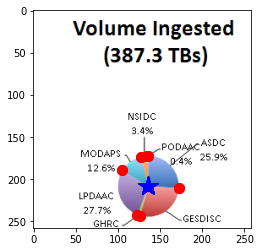

In [6]:
for i in range(10):
    img, kps = dataset[i]
    print(img.shape, kps)
    plt.imshow(img.permute(1,2,0))
    for kp in kps:
        marker = ".r" if kp[2] == "value_point" else "*b"
        plt.plot(kp[0], kp[1], marker, markersize=20)
    plt.show()